In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
seed = 9033

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.1)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=20,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


print('Done.')

Loading data
Done.


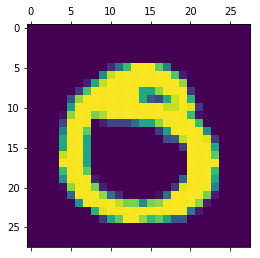

In [4]:
plt.matshow(data_labeled['image'][0, :, :])

In [5]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [6]:
latent_dim = 5
n_classes = 10

In [7]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [8]:
# Load results

enc_file = "../mnist_vae_results_aws/mnist_vae3_semisupervised_enc_epoch30"
dec_file = '../mnist_vae_results_aws/mnist_vae3_semisupervised_dec_epoch30'
classifier_file = '../mnist_vae_results_aws/mnist_vae3_semisupervised_classifier_epoch30'
vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

RuntimeError: Error(s) in loading state_dict for MLPEncoder:
	While copying the parameter named "fc1.weight", whose dimensions in the model are torch.Size([128, 794]) and whose dimensions in the checkpoint are torch.Size([128, 784]).

In [ ]:
print(vae.parameters)

In [ ]:
loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae2_semisupervisedloss_array.txt')

In [ ]:
plt.plot(loss_array[0, :], loss_array[1, :], '+')
plt.plot(loss_array[0, :], loss_array[2, :], '+')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

In [ ]:
vae.loss(data_unlabeled['image'])[0]

In [ ]:
vae.loss(test_data['image'])[0]

In [ ]:
# check a few train images

In [ ]:
latent_means, latent_std, latent_samples, class_weights = \
    vae.encoder_forward(data_unlabeled['image'])

z_ind = torch.argmax(class_weights, dim = 1)
    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind)

In [ ]:
class_weights

In [ ]:
for i in range(10): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('true class label: {} \n predicted class label: {}\n'.format(data_unlabeled['label'][i], z_ind[i]))

In [ ]:
# check a few test images 

In [ ]:
latent_means, latent_std, latent_samples, class_weights = \
    vae.encoder_forward(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)

image_mu, image_std = vae.decoder_forward(latent_means, z_ind)

In [ ]:
for i in range(10): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('true class label: {} \n predicted class label: {}\n'.format(test_data['label'][i], z_ind[i]))

In [ ]:
_, _, _, class_weights_unlab = \
    vae.encoder_forward(data_unlabeled['image'])

_, _, _, class_weights_lab = \
    vae.encoder_forward(data_labeled['image'])

_, _, _, class_weights_test = \
    vae.encoder_forward(test_data['image'])


In [ ]:
vae.get_class_label_cross_entropy(class_weights_unlab, data_unlabeled['label']) / len(data_unlabeled['label'])

In [ ]:
vae.get_class_label_cross_entropy(class_weights_lab, data_labeled['label']) / len(data_labeled['label'])

In [ ]:
vae.get_class_label_cross_entropy(class_weights_test, test_data['label'])  / len(test_data['label'])

In [ ]:
class_weights_test.shape

In [ ]:
class_weights_lab.shape

In [ ]:
plt.matshow(class_weights_lab.detach())

In [ ]:
common_utils.get_one_hot_encoding_from_int(test_data['label'], vae.encoder.n_classes).shape